In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from pointprocess import *
from lightning_setup import *

In [2]:
c = Region(city=cities['cedar'])
c.define_grid()

In [ ]:
for y in range(1991, 2016):
    amplitude_of_CG(y)

In [ ]:
for y in range(2010, 2016):
    fig_1(y)

In [84]:
def amplitude_of_CG(y):
    # years between 2006 and 2010 might contain CC
    ds = xr.open_mfdataset(c.PATH+'{y}_*_*.nc'.format(y=y))
    df = ds.to_dataframe()
    ds.close()

    x = list(range(-100, 101))
    if y<2010:
        CG = np.histogram(df['amplitude'], bins=x)[0]
    else:
        CG = np.histogram(df[df['cloud_ground'] == b'G']['amplitude'], bins=x)[0]

    title = 'Amplitude of flashes Cedar City {y}'.format(y=y)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    ax.plot(x[:-1], CG, 'red')
    ax.legend(['CG flashes'])
    ax.set_ylabel('Count')
    ax.set_ylim(0, 45000)
    ax.set_title(title)

    plt.savefig('./output/after_Villarini_2012/{title}.png'.format(title=title))

In [82]:
def fig_1(y):
    ds = xr.open_mfdataset(c.PATH+'{y}_*_*.nc'.format(y=y))
    df = ds.to_dataframe()
    ds.close()

    x = list(range(-100,101))
    CG = np.histogram(df[df['cloud_ground'] == b'G']['amplitude'], bins=x)[0]
    CC = np.histogram(df[df['cloud_ground'] == b'C']['amplitude'], bins=x)[0]
    fractional_CC = np.clip(np.nan_to_num(CC/CG), 0, 1)

    title = 'Fig 1 Cedar City {y}'.format(y=y)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
    axes[0].plot(x[:-1], CC, 'blue')
    axes[0].plot(x[:-1], CG, 'red')
    axes[0].legend(['CC flashes', 'CG flashes'])
    axes[0].set_ylabel('Count')
    axes[0].set_ylim(0, 160000)
    axes[0].set_title(title)
    axes[1].plot(x[:-1], fractional_CC, 'k')
    axes[1].set_ylabel('Fraction of CC flashes')
    axes[1].set_xlabel('Peak current (kA)')
    axes[1].fill_between(x[:-1], 0, fractional_CC, facecolor='gray')

    plt.savefig('./output/after_Villarini_2012/{title}.png'.format(title=title))

In [ ]:
df_15 = None
df_40 = None
df_0 = None
df_10 = None

for y in range(1991,2016):
    ds = xr.open_mfdataset(c.PATH+'{y}_*_*.nc'.format(y=y))
    df = ds.to_dataframe()
    df.index = df.time
    ds.close()
    
    df0 = df[df['amplitude'] > 15]
    df_15 = pd.concat([df_15, df0['amplitude'].resample('24H', base=12).count()])
    
    df0 = df[df['amplitude'] > 40]
    df_40 = pd.concat([df_40, df0['amplitude'].resample('24H', base=12).count()])
    
    df0 = df[df['amplitude'] < 0]
    df_0 = pd.concat([df_0, df0['amplitude'].resample('24H', base=12).count()])
    
    df0 = df[df['amplitude'] < -10]
    df_10 = pd.concat([df_10, df0['amplitude'].resample('24H', base=12).count()])

In [106]:
df_15.name = 'FC_amplitude>15'
df_40.name = 'FC_amplitude>40'
df_0.name = 'FC_amplitude<0'
df_10.name = 'FC_amplitude<-10'

df = pd.DataFrame(df_15).join(df_40).join(df_0).join(df_10)
computed = pd.HDFStore('computed.h5')
computed['cedar_daily_12UTCto12UTC_filtered_amplitude'] = df
computed.close()

In [5]:
computed = pd.HDFStore('computed.h5')
df = computed['cedar_daily_12UTCto12UTC_filtered_amplitude']
computed.close()

In [27]:
top = {}
for lim in ['>15', '>40', '<0', '<-10']:
    top.update({lim:df.sort_values('FC_amplitude{lim}'.format(lim=lim), ascending=False).index[:80]})

top.update({'<0 or >15': (df['FC_amplitude<0']+ df['FC_amplitude>15']).sort_values(ascending=False).index[:80]})
top.update({'<-10 or >40': (df['FC_amplitude<-10']+ df['FC_amplitude>40']).sort_values(ascending=False).index[:80]})

In [78]:
month_dict = {}
year_dict = {}
for k, v in top.items():
    gb = v.groupby(v.year)
    year_hist = np.array([len(gb.get(year, [])) for year in range(1991, 2016)])
    year_dict.update({k: year_hist})
    gb = v.groupby(v.month)
    month_hist = np.array([len(gb.get(month, [])) for month in range(1, 13)])
    month_dict.update({k: month_hist})
year_df = pd.DataFrame.from_dict(year_dict)
year_df.index = list(range(1991,2016))
month_df = pd.DataFrame.from_dict(month_dict)
month_df.index = list(range(1,13))

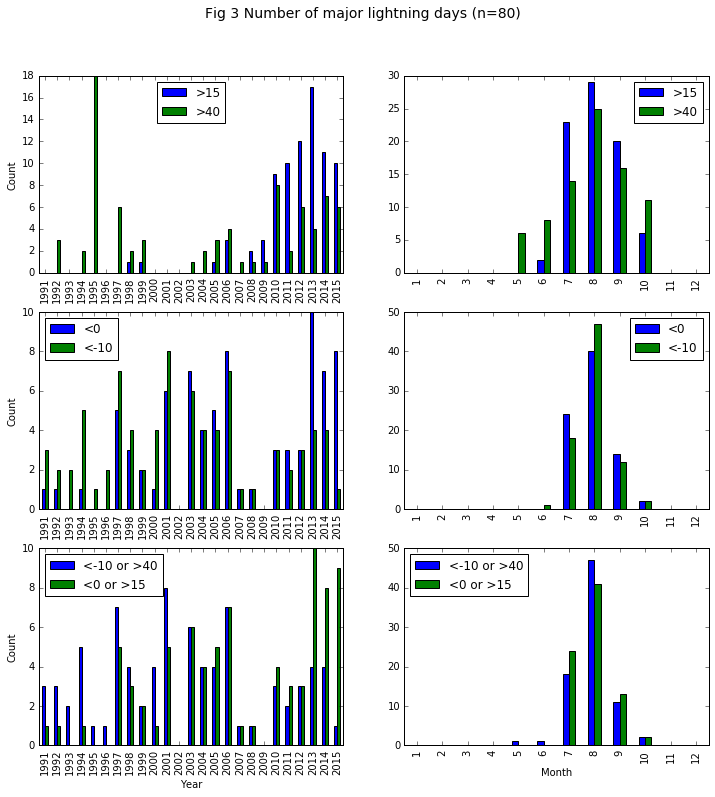

In [100]:
title  ='Fig 3 Number of major lightning days (n=80)'
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
fig.suptitle(title, fontsize=14)

year_df[['>15', '>40']].plot.bar(ax=axes[0,0])
month_df[['>15', '>40']].plot.bar(ax=axes[0,1])
year_df[['<0', '<-10']].plot.bar(ax=axes[1,0])
month_df[['<0', '<-10']].plot.bar(ax=axes[1,1])
year_df[['<-10 or >40', '<0 or >15']].plot.bar(ax=axes[2,0])
month_df[['<-10 or >40', '<0 or >15']].plot.bar(ax=axes[2,1])
for ax in axes[:,0]:
    ax.set_ylabel('Count')
axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Month')

plt.savefig('./output/after_Villarini_2013/{title}.png'.format(title=title))